# Make counterfact color dataset
This notebook creates a dataset of real-world objects colored **with a counterfact color that contradicts known color priors for the given object**.
Images are obtained through targeted queries in *query_google_images.ipynb* and segmented to produce binary foreground masks using *segment_outline.ipynb*.
Using these masks, foreground and background regions are colored independently, enabling controlled manipulations of object color while preserving object identity.
Recoloring is implemented via *recolor_images.py*.

In [1]:
%reload_ext autoreload
%autoreload 2

from transformers import (
    BitsAndBytesConfig,
    LlavaNextProcessor,
    LlavaNextForConditionalGeneration
)
import torch
import pandas as pd
import re
import gc
import numpy as np
from tqdm import tqdm
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt

ROOT = Path().resolve().parents[0]
sys.path.insert(0, str(ROOT))

from model_evaluation.test_MLLMs import run_vlm_evaluation
from making_color_images.model_priors import TorchColorPriors, GPTColorPriors
from making_color_images.plot_variants import collect_variants_for, show_variants_grid, plot_vlm_performance, variant_label
from making_color_images.recolor_images import generate_variants, resize_all_images_and_masks


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

fontsize = 14

In [2]:
# Set a specific seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True
)

torch.cuda.empty_cache()
gc.collect()

Using device: cuda


60

In [3]:
# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
DATA = WORK / "color-concept-entanglement" / "data"

FRUIT = DATA / "fruit"
OUTLINES = DATA / "color_images"

RESIZED_IMGS = DATA / "resized_images"
RESIZED_MASKS = DATA / "resized_cv_masks"
RESIZED_IMGS.mkdir(parents=True, exist_ok=True)
RESIZED_MASKS.mkdir(parents=True, exist_ok=True)

In [4]:
# Define the percentage grid for coloring
pct_schedule = list(range(0, 11, 1)) + list(range(20, 60, 10)) + list([55]) + list(range(60, 110, 10))
print("Percentage grid:", pct_schedule)

Percentage grid: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 55, 60, 70, 80, 90, 100]


## 1. Load base dataframe

In [15]:
# Load dataframe with outline images and masks
df = pd.read_csv(DATA / "segmented_images.csv")
display(df)

# Counterfact colors in df
df["incorrect_answer"].unique().tolist()

df["incorrect_answer"].value_counts()

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,['yellow'],purple,sunflower,https://thumbs.dreamstime.com/b/black-outline-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,"['brown', 'black', 'orange']",green,tabby,https://img.recraft.ai/5P-WlUIGI2MwJC2v_JyrGkp...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,"['pink', 'white']",green,spoonbill,https://img.freepik.com/premium-vector/drawing...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,['white'],green,Samoyed,https://img.freepik.com/premium-photo/black-wh...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
215,"['gold', 'silver']",green,crown,https://i.pinimg.com/736x/32/52/35/325235d85fb...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",42.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
216,"['orange', 'white']",purple,pill bottle,https://media.istockphoto.com/id/470313936/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
217,['black'],pink,dial telephone,https://png.pngtree.com/png-clipart/20230811/o...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
218,['black'],pink,digital watch,https://img.freepik.com/premium-vector/digital...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",34.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


incorrect_answer
purple    40
pink      40
green     33
blue      31
yellow    25
red       20
orange    20
brown     11
Name: count, dtype: int64

In [17]:
df[df["incorrect_answer"] == "brown"]

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
7,"['silver', 'black']",brown,car wheel,https://www.shutterstock.com/image-illustratio...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
52,['white'],brown,airliner,https://www.shutterstock.com/image-vector/airl...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",45.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
89,['yellow'],brown,forklift,https://img.freepik.com/premium-photo/forklift...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",45.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
152,['silver'],brown,flute,https://i.pinimg.com/1200x/40/5b/32/405b322e16...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",43.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
156,['green'],brown,celery,https://img.freepik.com/premium-vector/celery-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",43.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
163,"['red', 'white', 'green']",brown,Christmas stocking,https://i.pinimg.com/474x/89/aa/6a/89aa6a3b910...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",43.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
166,['red'],brown,wagon,https://i.pinimg.com/736x/5d/e3/60/5de36055350...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",43.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
170,['green'],brown,lime,https://images.vexels.com/media/users/3/238297...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",43.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
181,"['yellow', 'white']",brown,bus,https://img.freepik.com/premium-vector/black-w...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",43.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
198,['white'],brown,toilet,https://img.freepik.com/premium-vector/black-w...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",43.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


In [18]:
# Change some of the counterfact colors by hand to ensure better color contrasts
objects_to_change = ["wagon", "plunger", "flute", "car wheel"]
new_colors = ["orange", "blue", "orange", "yellow"]
for obj, new_col in zip(objects_to_change, new_colors):
    df.loc[df["object"] == obj, "incorrect_answer"] = new_col

In [21]:
df = resize_all_images_and_masks(
    df,
    img_out_folder=RESIZED_IMGS,
    mask_out_folder=RESIZED_MASKS,
    target_size=512,              # or 256, 384, 1024
    mask_column="cv_mask_path",   
    img_column="image_path"
)


Resizing all: 100%|██████████| 4/4 [00:00<00:00, 25.65it/s]

Resized 4 images.


In [22]:
suffix = "counterfact"
model_name = "gpt-4o"
coloring_modes = ["sequential"] #, "independent"]
OUT_COLOR = OUTLINES / model_name / suffix
OUT_COLOR.mkdir(parents=True, exist_ok=True) 
print(f"Output directory: {OUT_COLOR}") 

Output directory: /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/color_images/gpt-4o/counterfact


In [23]:
for _, row in tqdm(df.iterrows(), total=len(df), desc="Generating color variants"):
    for color_mode in coloring_modes:
        paths = generate_variants(
            row=row,
            target_color=row['incorrect_answer'],
            out_dir=OUT_COLOR,
            rng=rng,
            use_patches=True,
            patch_size=16,
            mode=color_mode,
            pct_schedule=pct_schedule
        )

Generating color variants: 100%|██████████| 4/4 [00:32<00:00,  8.02s/it]


In [24]:
# Define which range of image variants to plot
tail_range = list(range(0, 6)) + list(range(95, 101))
ten_increase = list(range(0, 110, 10))
compact = [0, 10, 50, 90, 100]

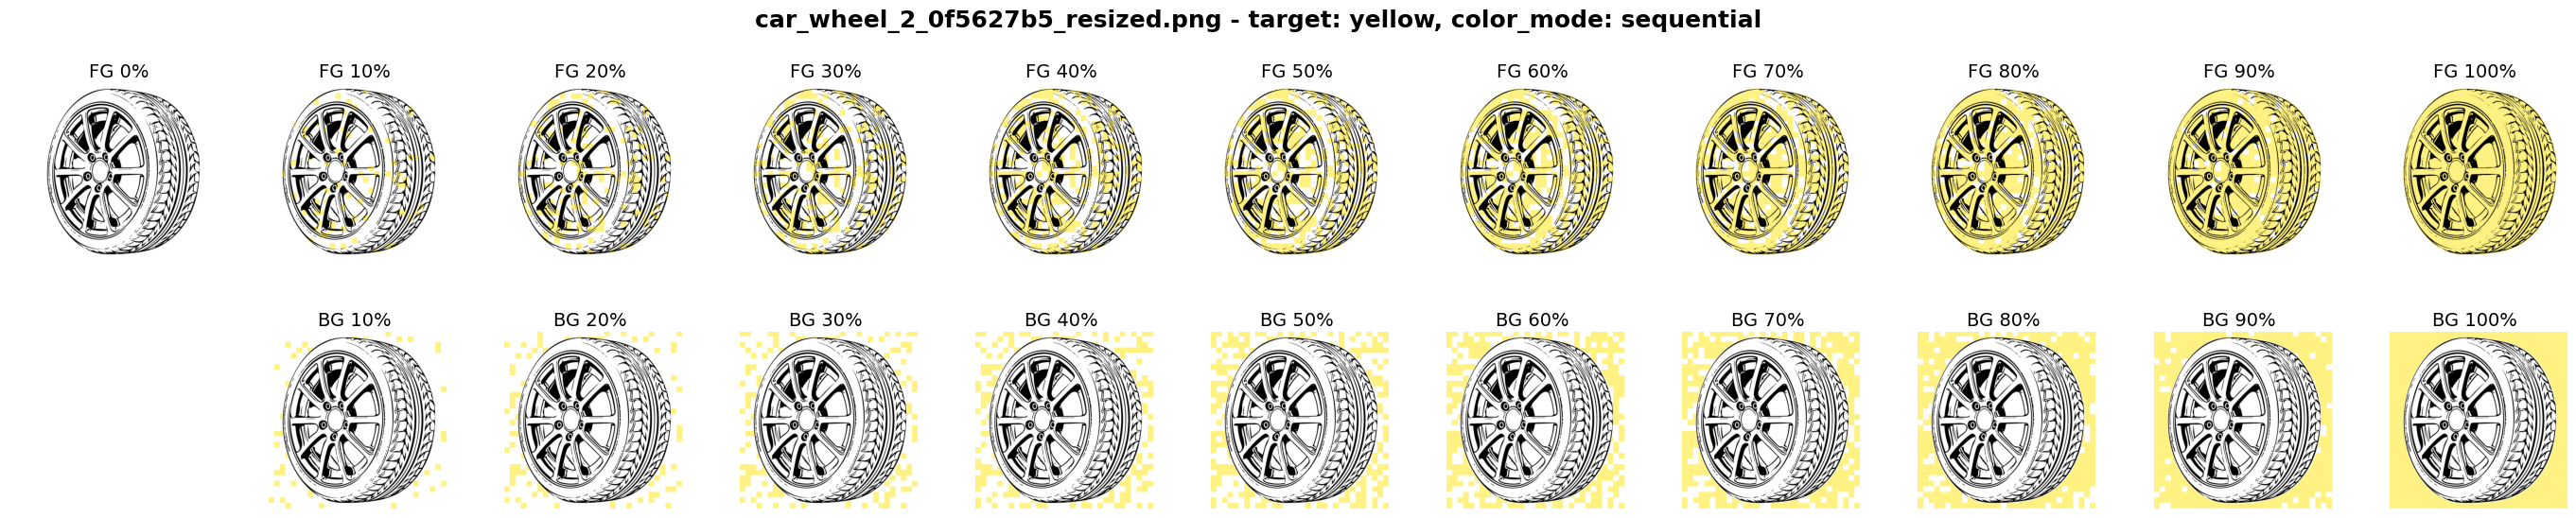

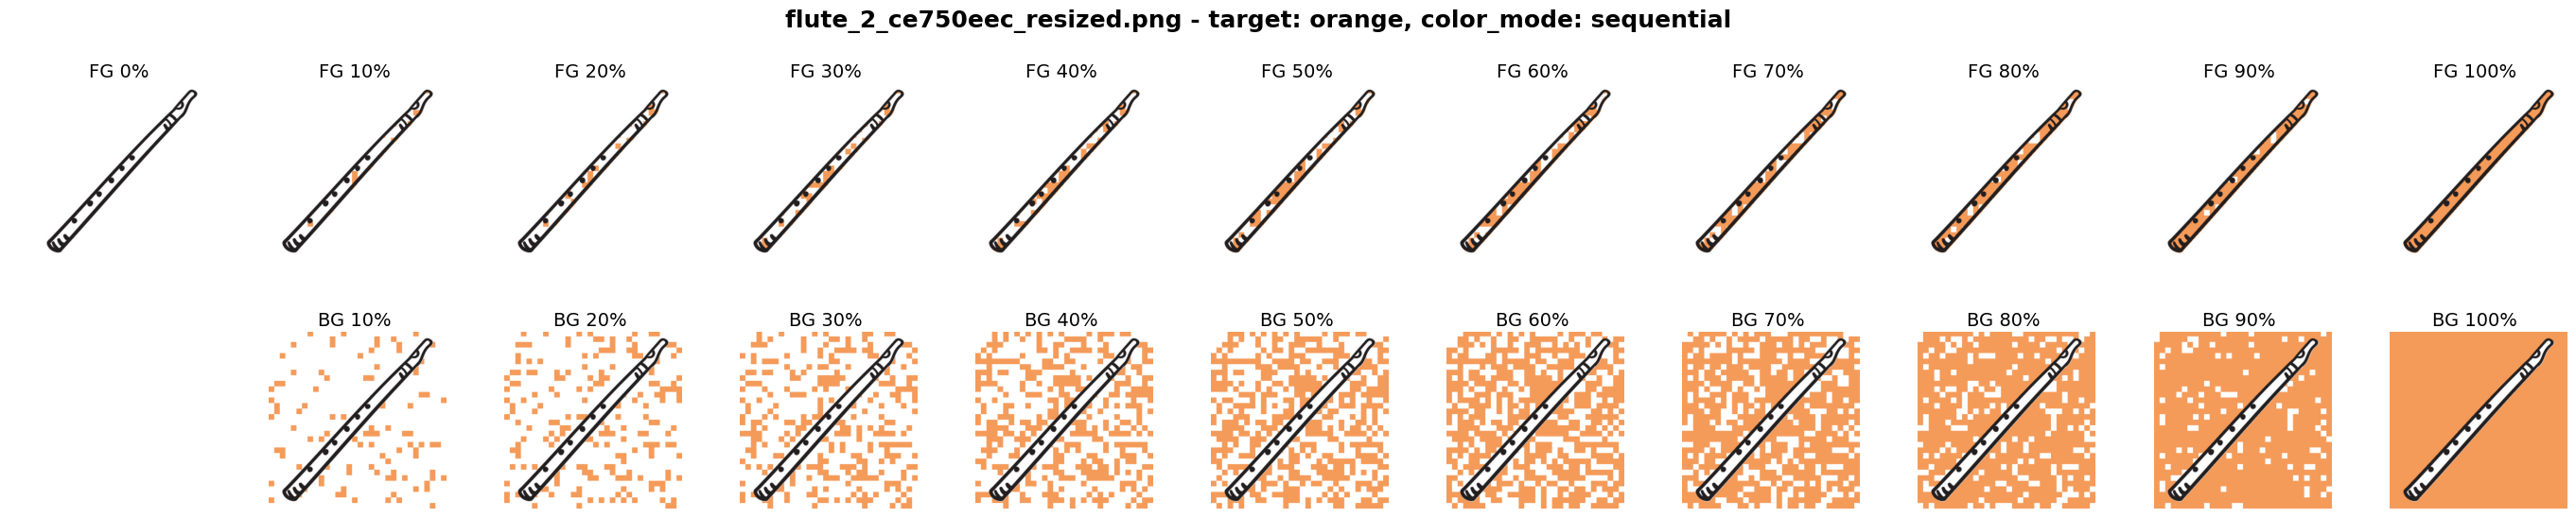

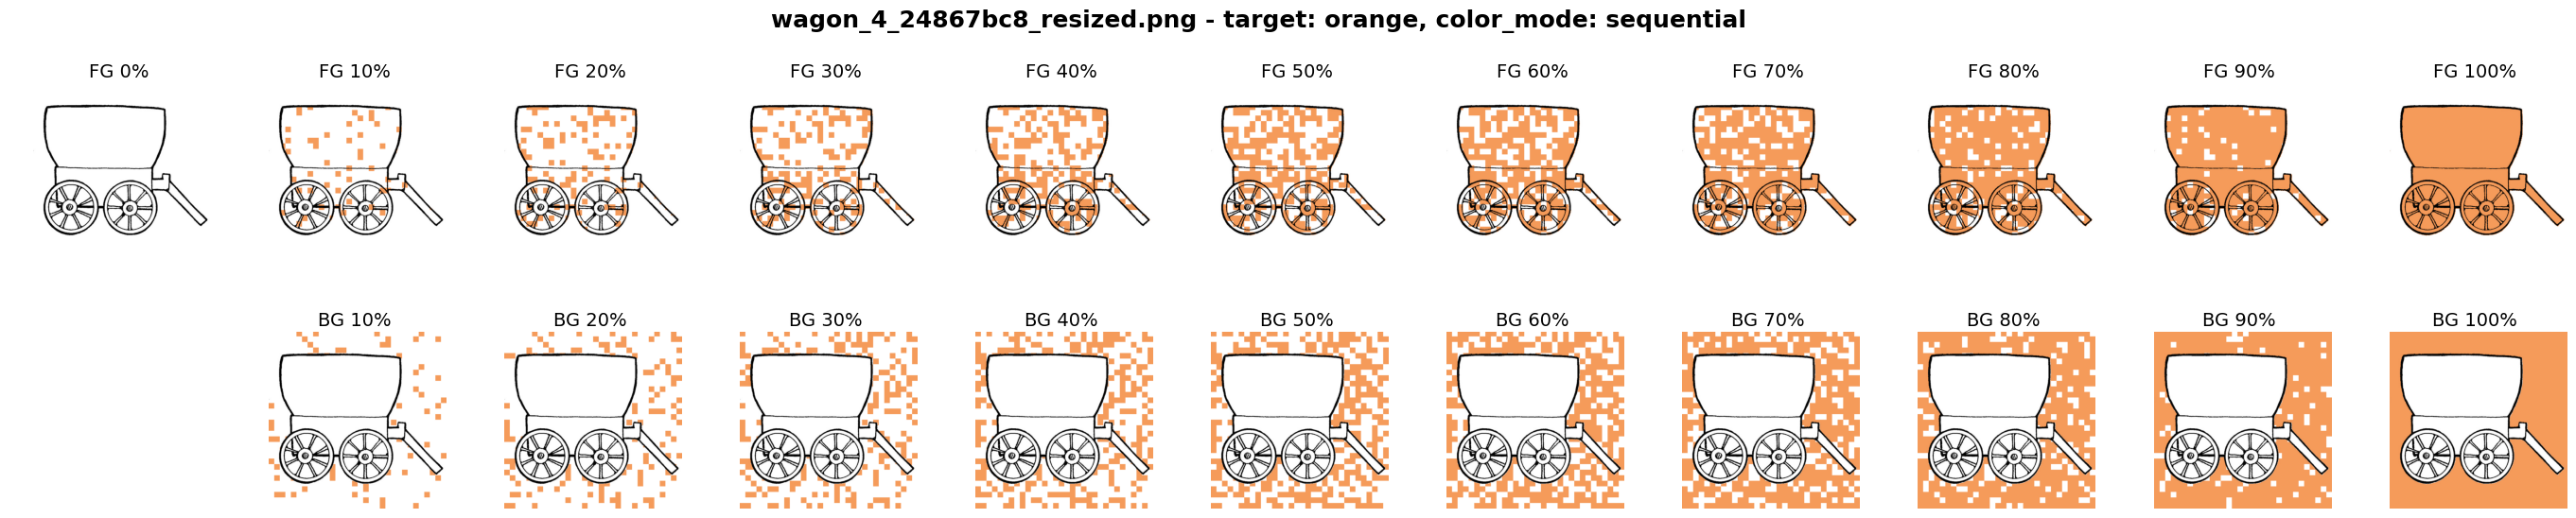

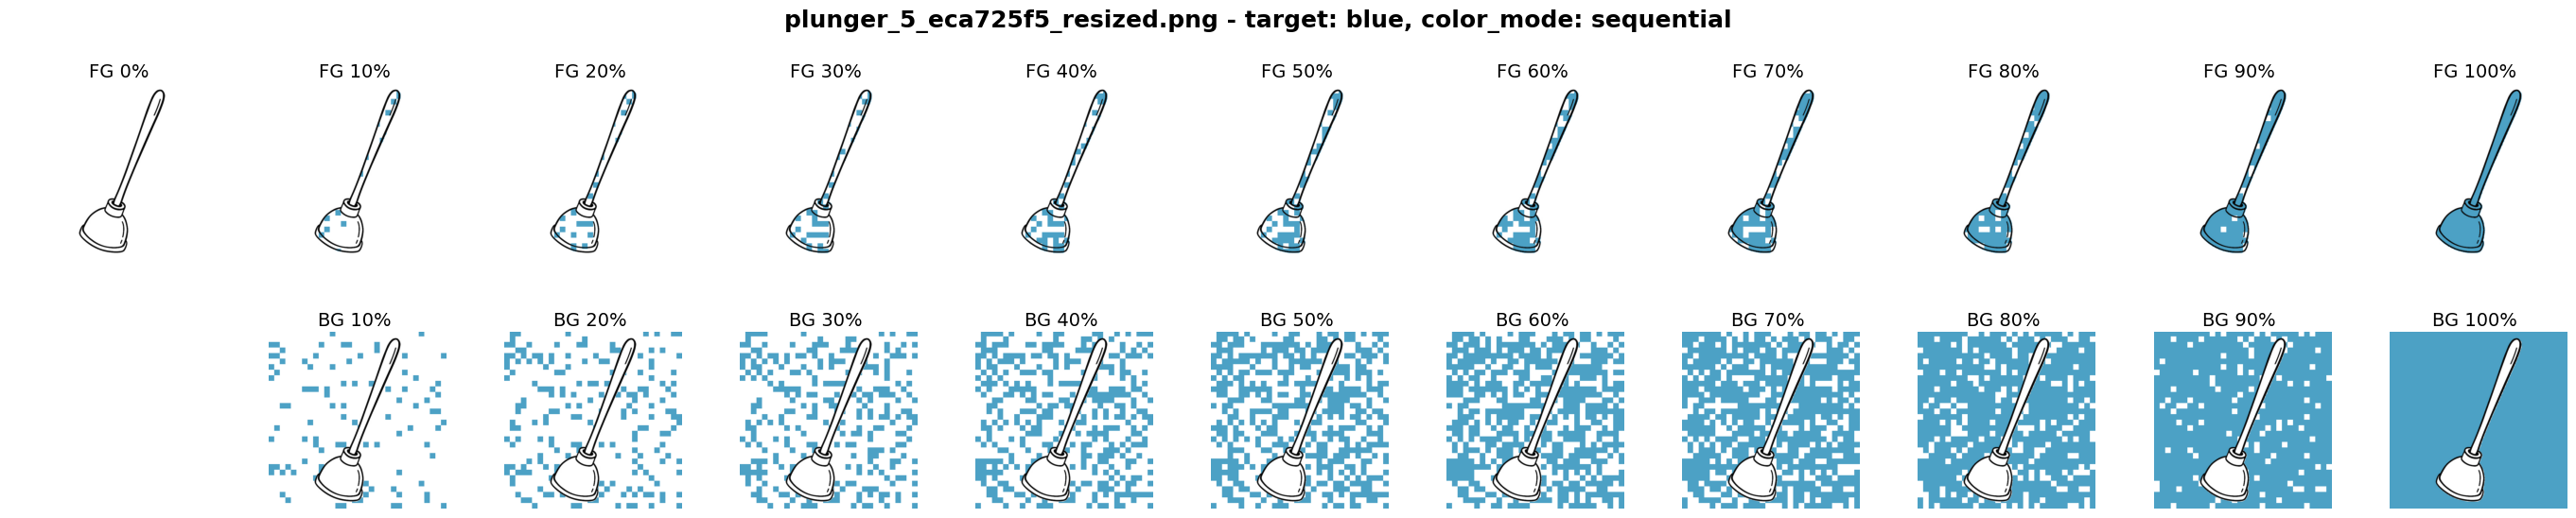

In [25]:
for idx, row in df.head(5).iterrows():
    for color_mode in coloring_modes:
        show_variants_grid(row['image_path'], row['incorrect_answer'], OUT_COLOR, color_mode=color_mode, pct_range=ten_increase)